# RHLF 
Source: https://www.youtube.com/watch?v=qGyFrqc34yc

RHLF is used to align the behavior of a language model in a way we want it to behave!

# Language Model
a probabilistice model that assing probabilities to sequences of words. P(Next token | Previous tokens). 
To generate a complete answer to a prompt, a language model is iteratively queried by adding the previously chosen token to the input. 
By just pre-training we do not teach the model not to use offensive language or harmful content. The goal of AI alignment is to align the model behavior with certain behavior that we want it to have.


# RL & Language Models
Language model could be considered as a policy itself. The prompt is the state and the next token is the aciotn. The missing part is the reward function. How can we reward the language model for good responses and how can we penalize the model for bad responses?

# Reward Modeling
It's not easy to come up with a number that can be accepted by everyone! However, we as humans are very good at comparing :D

Right now we can use a high temperature LM to generate multiple (two) responses to a given prompt. Then we can ask humans to compare the two responses and choose the better one. We can then generate a model that can generate the numeric reward for a given prompt and response pair. This is called reward modeling.

A neural network taking as input the prompt and the response and outputting a scalar reward. The preferred response should get a higher reward.


![Screenshot 2025-11-04 at 12.39.44 PM.png](<attachment:Screenshot 2025-11-04 at 12.39.44 PM.png>)

## Reward model loss
Our dataset is made up of questions and possible answers. Suppose there are only two answers! A good and a bad one.
We feed the question along with the answer to the model. We do this for both answers and get two scalar reward. 

Let's assume that model assinged high reward to the good one and low reward to the bad one --> We'll get small loss
Now let's assume that the model gave high reward to the bad response and low reward to the good response --> We'll get big loss

![Screenshot 2025-11-04 at 12.45.24 PM.png](<attachment:Screenshot 2025-11-04 at 12.45.24 PM.png>)



# RL

The expected return of a policy is the expected return over all possible trajectories! 

$\mathcal{J}(\pi) = \int_{\tau} p(\tau|\pi) R(\tau) = E_{\tau \sim p(\tau|\pi)}[R(\tau)]$

A trajectory is a series of actions and states, starting from an initial state. 

$ \tau = (s_0, a_0, s_1, a_1, ..., s_T, a_T)$

We wil model the next state as being stochastic 

$ s_{t+1} \sim P(s_{t+1}|s_t, a_t)$

We can define the probability of a trajectory given a policy as

$ p(\tau|\pi) = p(s_0) \prod_{t=0}^{T} \pi(a_t|s_t) P(s_{t+1}|s_t, a_t)$


![Screenshot 2025-11-04 at 1.03.33 PM.png](<attachment:Screenshot 2025-11-04 at 1.03.33 PM.png>)


We always work with the discounted reward : 
$ R(\tau) = \sum_{t=0}^{T} \gamma^t r(s_t, a_t)$

So let's assume that in the case of the cat example. The cat goes to the left and then goes down. For this specific trajectory the discounted reward will be : 


$ R(\tau) = \gamma *(-1) + \gamma^8 * (100)$ where $ 0 <\gamma< 1$ 


## Trajectory in Language Models

![Screenshot 2025-11-04 at 1.56.40 PM.png](<attachment:Screenshot 2025-11-04 at 1.56.40 PM.png>)


Now imagine that we have a policy. Our goal is to optimize the policy to maximize the expected return according to some reward model that we have developed previously! Since we want to maximze the expected return, we should use gradient ascent instead of descent!

$ \mathcal{J}(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}[R(\tau)]$

$ \theta_{k+1} = \theta_k + \alpha \nabla_{\theta} \mathcal{J}(\pi_{\theta}) |_{\theta = \theta_k}$


The gradiet of the policy is known as policy gradient and the algorithm is called policy gradient algorihm :D


Now the problem is how to compute the gradient of the expected return? We'd need to evaluate it over all the possible trajectories, which is computationally intractable!


![Screenshot 2025-11-04 at 2.09.51 PM.png](<attachment:Screenshot 2025-11-04 at 2.09.51 PM.png>)


We still have the expectation over all the possible trajectories and still intractable! One way to calculate this expectation is to approximate it with a sample mean by collecting a set D of trajectories.

$ \hat g = \frac{1}{|D|} \sum_{\tau \in D} \sum_{t=0}^{T} \nabla_{\theta} log \pi_{\theta}(a_t|s_t) R(\tau)$

loss.backward() in pytorch will automatically calculate the $\nabla_{\theta} log \pi_{\theta}(a_t|s_t)$ part for us :D

This whole process is called REINFORCE algorithm. Now let's check Reinforce on the language model!

![Screenshot 2025-11-04 at 2.43.09 PM.png](<attachment:Screenshot 2025-11-04 at 2.43.09 PM.png>)

so far we now how to calculatethe log probabilities. We need to understand how to calculatet reward model

![Screenshot 2025-11-04 at 3.27.23 PM.png](<attachment:Screenshot 2025-11-04 at 3.27.23 PM.png>)


This method is called gradient policy optimization which works fine with the samll problems but have problems with high dimensional problems like language models.

The problem is that we are approximating $ E_{\tau \sim \pi_{\theta}}[R(\tau)]$ with samples from the same policy $ \pi_{\theta}$. The result will converage to the true expectation on average but it shows high variance! 
By the way the more sample the better the approximation but choosing so many samples from the language model is computationally expensive! So we need to find another appraoch to reduce the variance!


## Reducing Variance
Instead of using the total reward of the trajectory R(tau) for each time step, we can use the reward to go from that time step since the current action does not have any effect on the previous rewards!

![Screenshot 2025-11-05 at 11.53.29 AM.png](<attachment:Screenshot 2025-11-05 at 11.53.29 AM.png>)

The $\frac{1}{N} \sum_{i=1}^{N} (\sigma_{t=0}^(T) \nabla_{\theta} log \pi_{\theta}(a_{i,t}|s_{i,t}))(\sigma_{t=0}^{T} r(s_{i,t}, a_{i,t}))$ is the approximation of the $ E_{\tau \sim \pi_{\theta}}[R(\tau)]$ using N samples. So if we can remove some terms from this expression we are reducing the chance of getting some noise and changing the direction of the gradient too much. In summary, instead calculating the reward of all trajectory for each time step, we can just calculate the reward from that time step to the end of the trajectory. 


Another way to reduce the variance is to introduce a baseline that is subtracted from the reward.This constant baseline could be a function of the state. The function that we will choose is called the value function. The value function tells us teh expected reward from a given state following the current policy!

![Screenshot 2025-11-05 at 12.03.37 PM.png](<attachment:Screenshot 2025-11-05 at 12.03.37 PM.png>)

# Value function model

We add another linear layer to the language model to predict the value function. We use the same language model that we are trying to optimize. We add another linear layer. The parameters of the transformer layer are shared.  

![Screenshot 2025-11-05 at 12.13.47 PM.png](<attachment:Screenshot 2025-11-05 at 12.13.47 PM.png>)


The next point is that instead of using the reward to go, we can use the Q function. The Q function tells us the expected reward from a given state and action following the current policy!

Reward to Go is the suma of all future rewards starting from time step t. it deponds only on the trajectory that was actully experienced.
The Q function is the expected total future reward if we take action a in state s and then follow the current policy.


$ Q^{\pi}(s_t, a_t) = E_{s\prime}[r(s,a) + \gamma E_{a\prime}[Q^\pi(s\prime , a\prime)]]$

![Screenshot 2025-11-05 at 12.20.10 PM.png](<attachment:Screenshot 2025-11-05 at 12.20.10 PM.png>)


![Screenshot 2025-11-05 at 12.29.02 PM.png](<attachment:Screenshot 2025-11-05 at 12.29.02 PM.png>)

we are trying to push up the probabilities of those actions in a given state that results in a better than average reward 


## Estimating the Advantage Function

$ A(s_t, a_t) = Q^{\pi}(s_t, a_t) - V^{\pi}(s_t)$

$ A(s_t, a_t) = r(s_t, a_t) + \gamma V^{\pi}(s_{t+1}) - V^{\pi}(s_t)$

$ A(s_t, a_t) = r(s_t, a_t) + \gamma r(s_{t+1}, a_{t+1}) + \gamma^2 V^{\pi}(s_{t+2}) - V^{\pi}(s_t)$


![Screenshot 2025-11-05 at 12.46.51 PM.png](<attachment:Screenshot 2025-11-05 at 12.46.51 PM.png>)


The point is that if we stop too early, we will get a very high bias (because we are approximating the value function, and only using one "real" reward from our trajectory). If we stop after many terms, we will get a high variance (because we are using many "real" rewards from our trajectory). So we need to find a balance between bias and variance! --> Generalized Advantage Estimation (GAE)

We can use the wighted sum of these different estimators to get a better estimator!

$ \delta _t = r(s_t, a_t) + \gamma V^{\pi}(s_{t+1}) - V^{\pi}(s_t)$

$ \hat A_t^{GAE(\gamma, \lambda)} = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}$


![Screenshot 2025-11-05 at 12.54.43 PM.png](<attachment:Screenshot 2025-11-05 at 12.54.43 PM.png>)

To understand how to calculate the advantage function using GAE, take a look at the example above. Let's assume that our trajectory length is 3. We should start with calculating $A_3$ and then recursively calculate the previous advantage functions.


## Advantage term for language models

![Screenshot 2025-11-05 at 12.54.43 PM.png](<attachment:Screenshot 2025-11-05 at 12.54.43 PM.png>)



The second problem with the gradient policy optimization approach is the sampling problem. Consider the following gradient formula : 

$\nabla_{\theta} \mathcal{J}(\pi_{\theta}) = \frac {1}{N} \sum_{i=1}^{N} \sum_{t=0}^{T} \nabla_{\theta} log \pi_{\theta}(a_{i,t}|s_{i,t}) A^{\pi_{\theta}}(s_{i,t}, a_{i,t})$

The expectation forces us to sample trajectories from our neural network every time we update the parameters. This can be very inefficient because when training a neural network, we update the parameters many times by taking small steps. 

The formula for the gradient that we have found is an approximation of an expectation. In probability theory, there is a technique called importance sampling that allows us to approximate an expectation using samples from a different distribution.


![Screenshot 2025-11-05 at 1.53.07 PM.png](<attachment:Screenshot 2025-11-05 at 1.53.07 PM.png>)


Then the off-policy learning would be like : 

![Screenshot 2025-11-05 at 3.07.29 PM.png](<attachment:Screenshot 2025-11-05 at 3.07.29 PM.png>)


and the pseudo code would be like :
 
![Screenshot 2025-11-05 at 3.08.01 PM.png](<attachment:Screenshot 2025-11-05 at 3.08.01 PM.png>)

The PPO loss is as follows:



The min help use to make the most pessimistic update!

![Screenshot 2025-11-05 at 8.40.53 PM.png](<attachment:Screenshot 2025-11-05 at 8.40.53 PM.png>)


The final point is that we want the optimized model to generate answers that make sense. It should not just try to maximize the reward. For instance imagine a case where the reward is being assigned to being polite. Then the answer for all questions will become Thank you! 

We want answers that are aligned with the reward and are in the distribution of the pre-trained language model. To achieve this we can add a KL divergence penalty between the optimized model and the pre-trained model to the loss function.

![Screenshot 2025-11-05 at 8.54.01 PM.png](<attachment:Screenshot 2025-11-05 at 8.54.01 PM.png>)

we want to penalize the model from generating the answers that are very different from the pre-trained model! The reward at each timestep is modified as follows:
$ r(s_t, a_t) = r_{RM}(s_t, a_t) - KL (\pi_{\theta}( . | s_t) || \pi_{pre}(. | s_t))$

where $ r_{RM}(s_t, a_t)$ is the reward from the reward model.
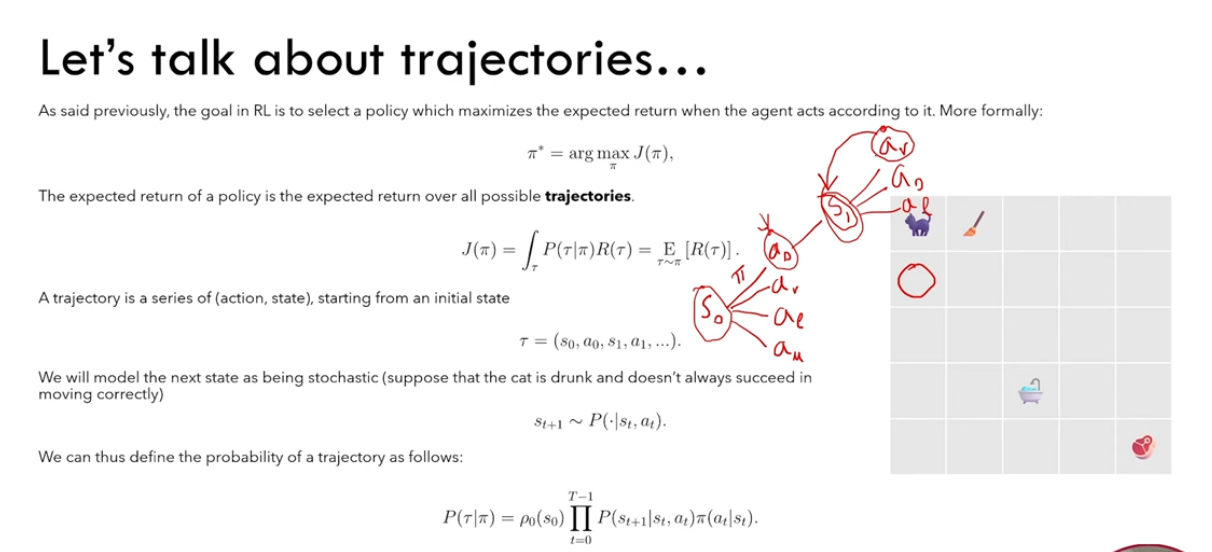
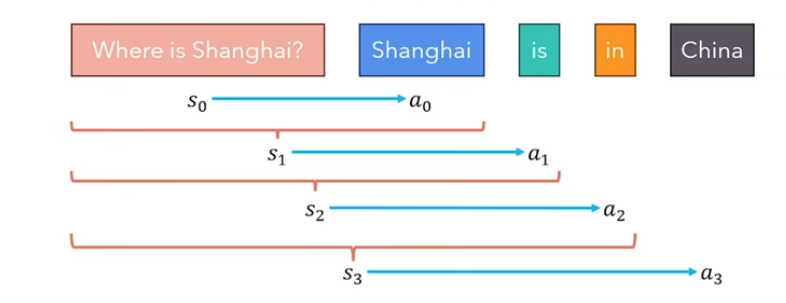
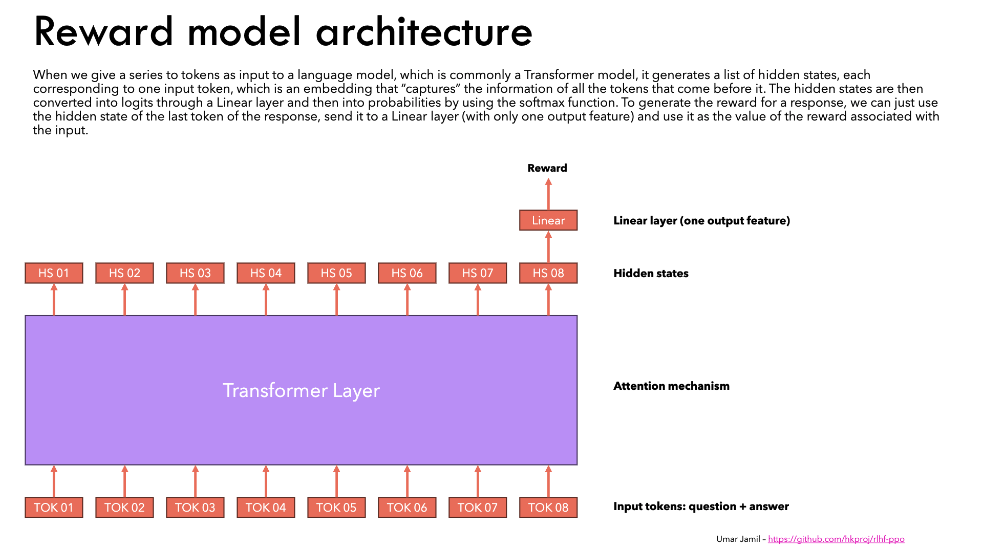
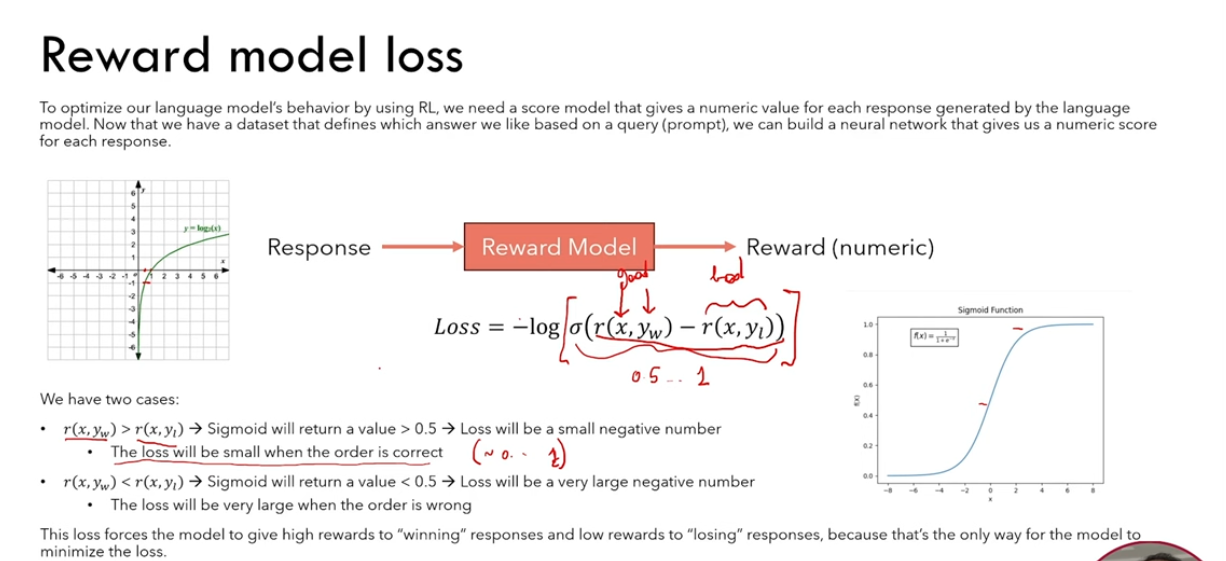
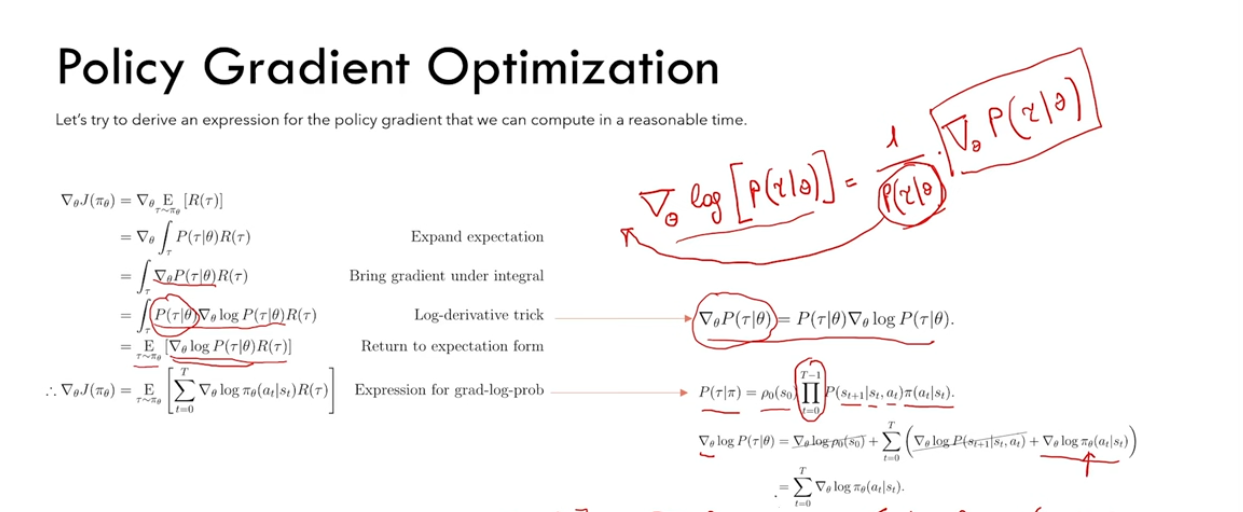
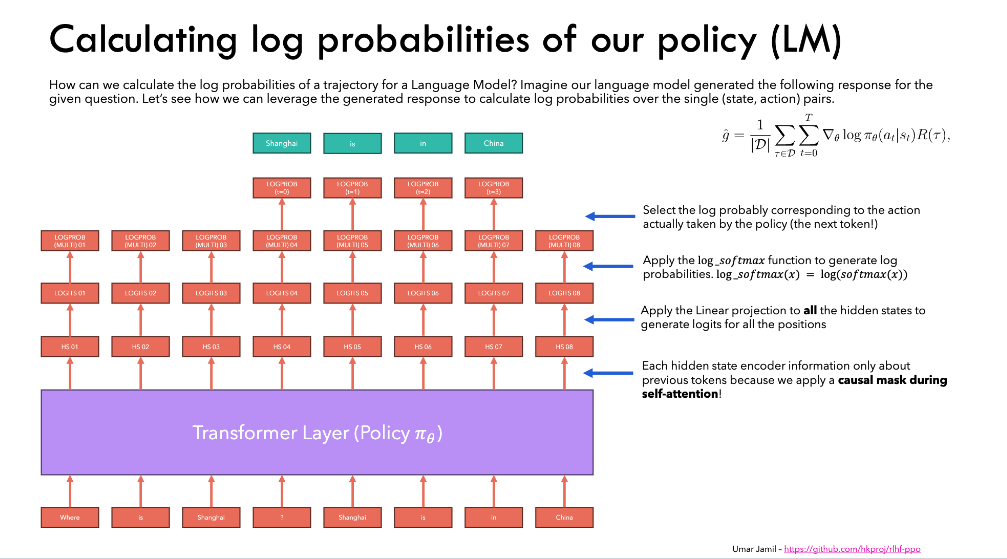
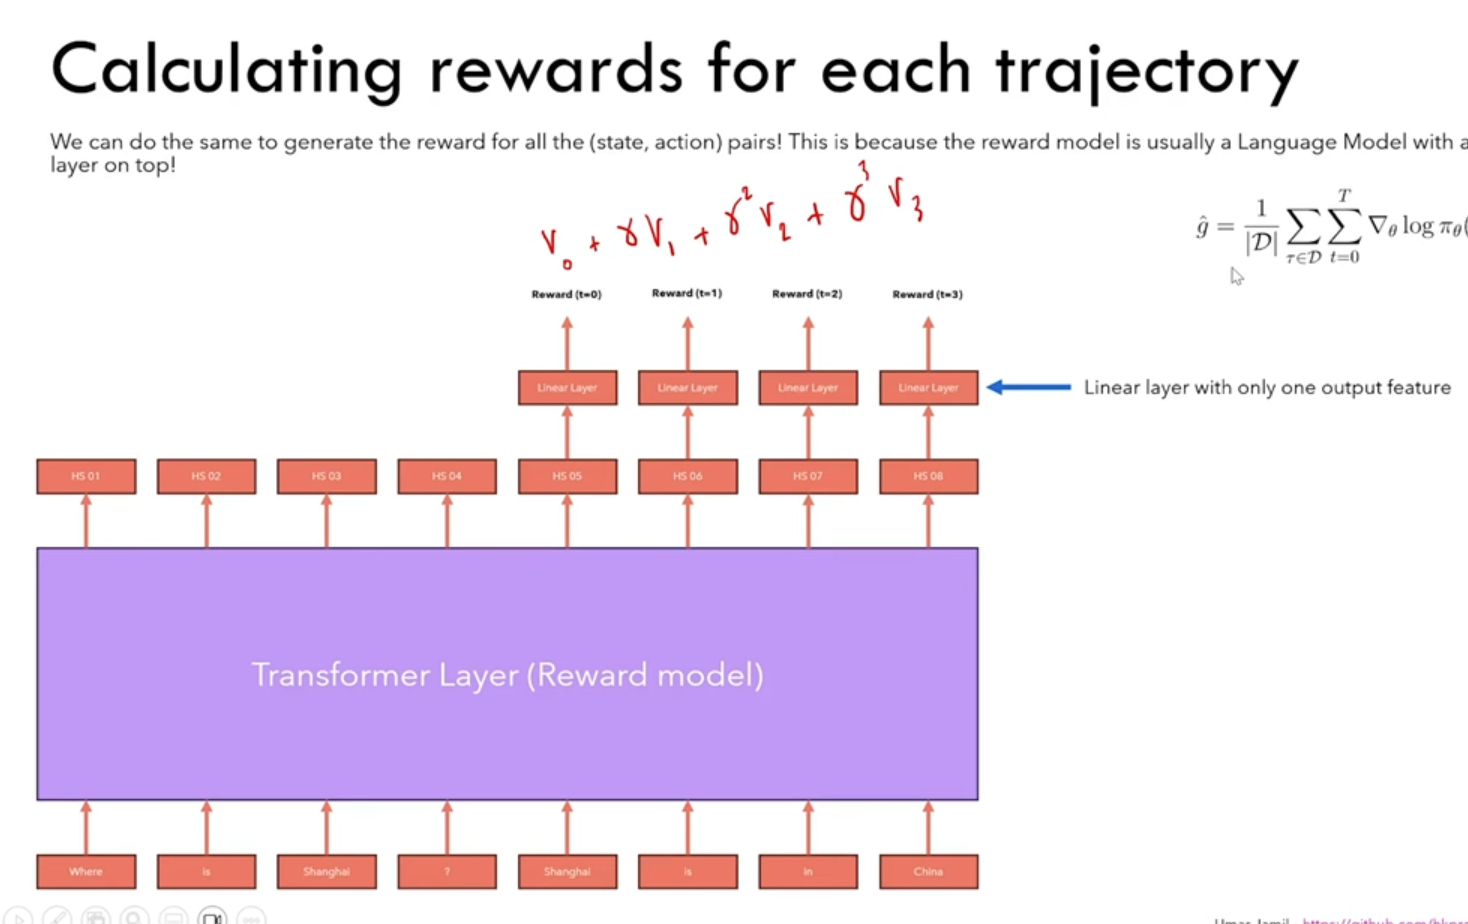
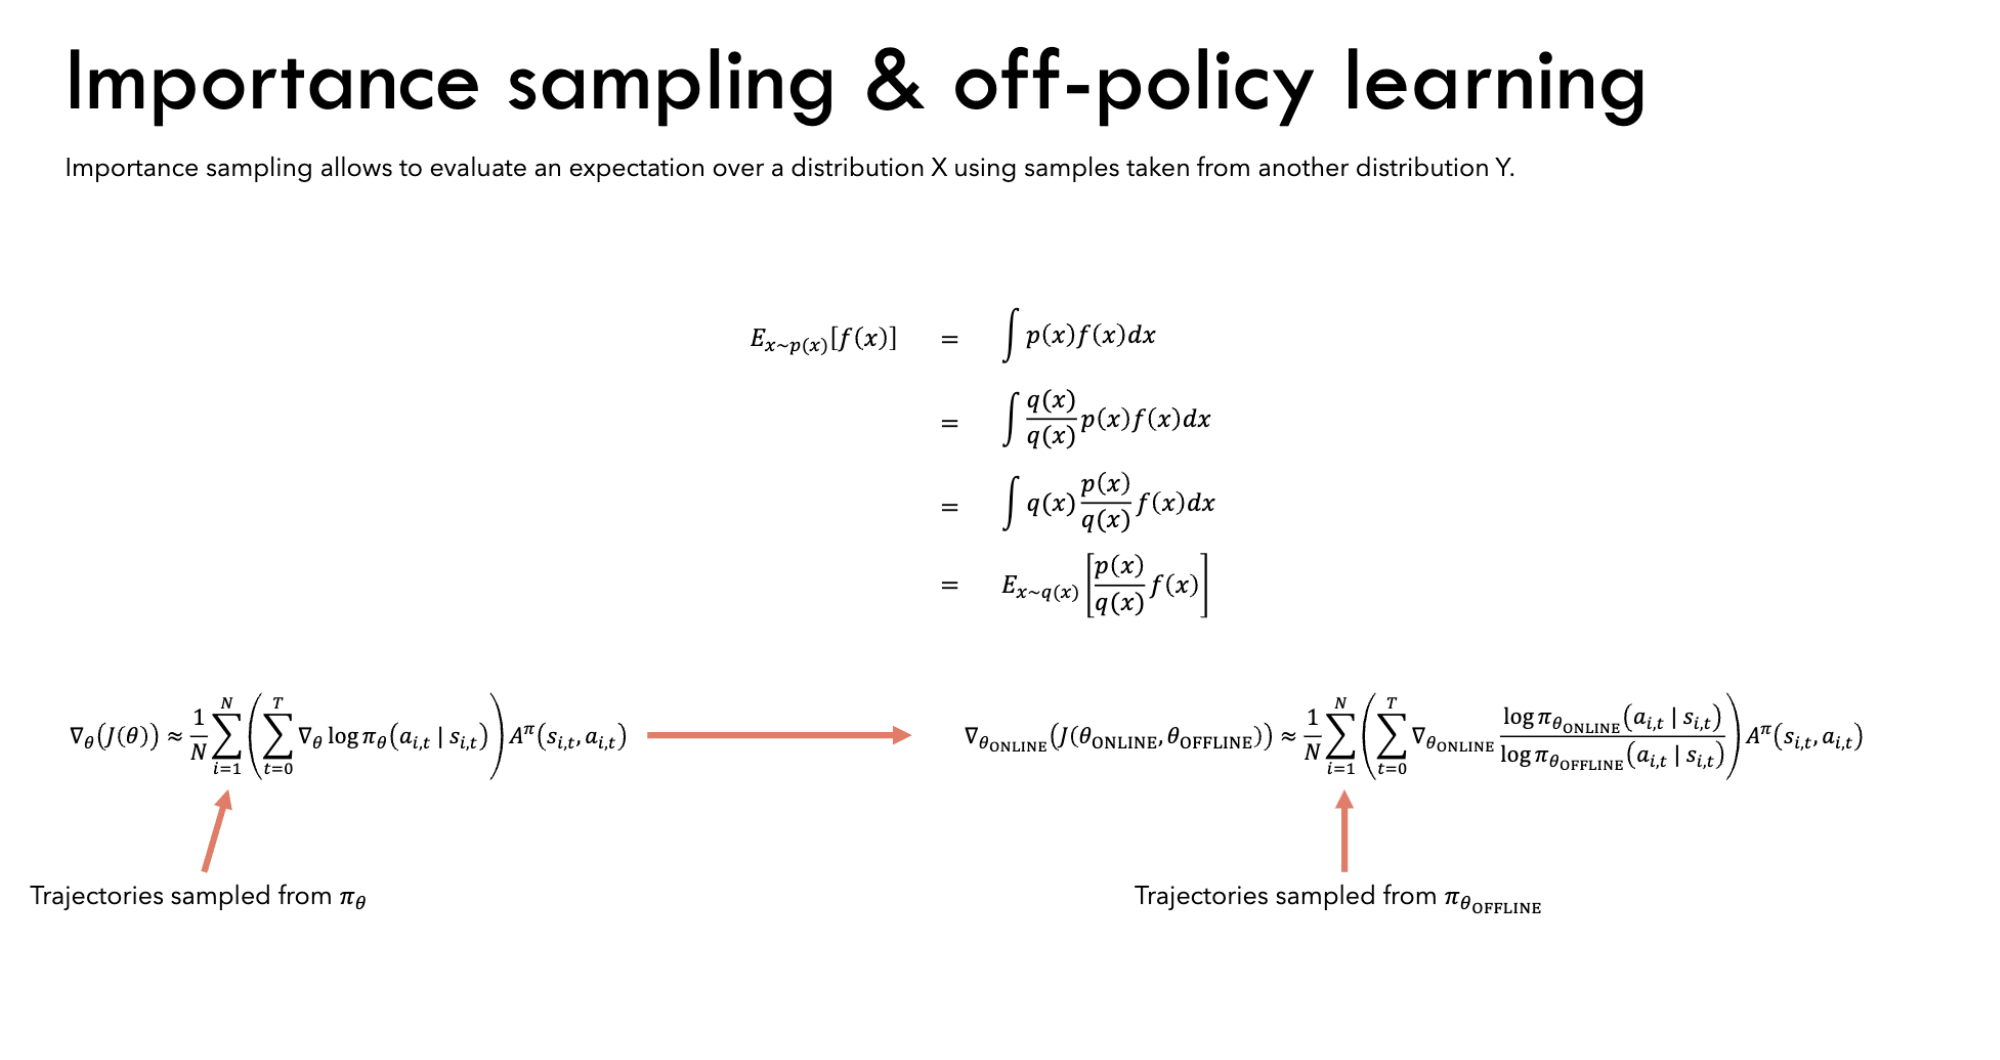
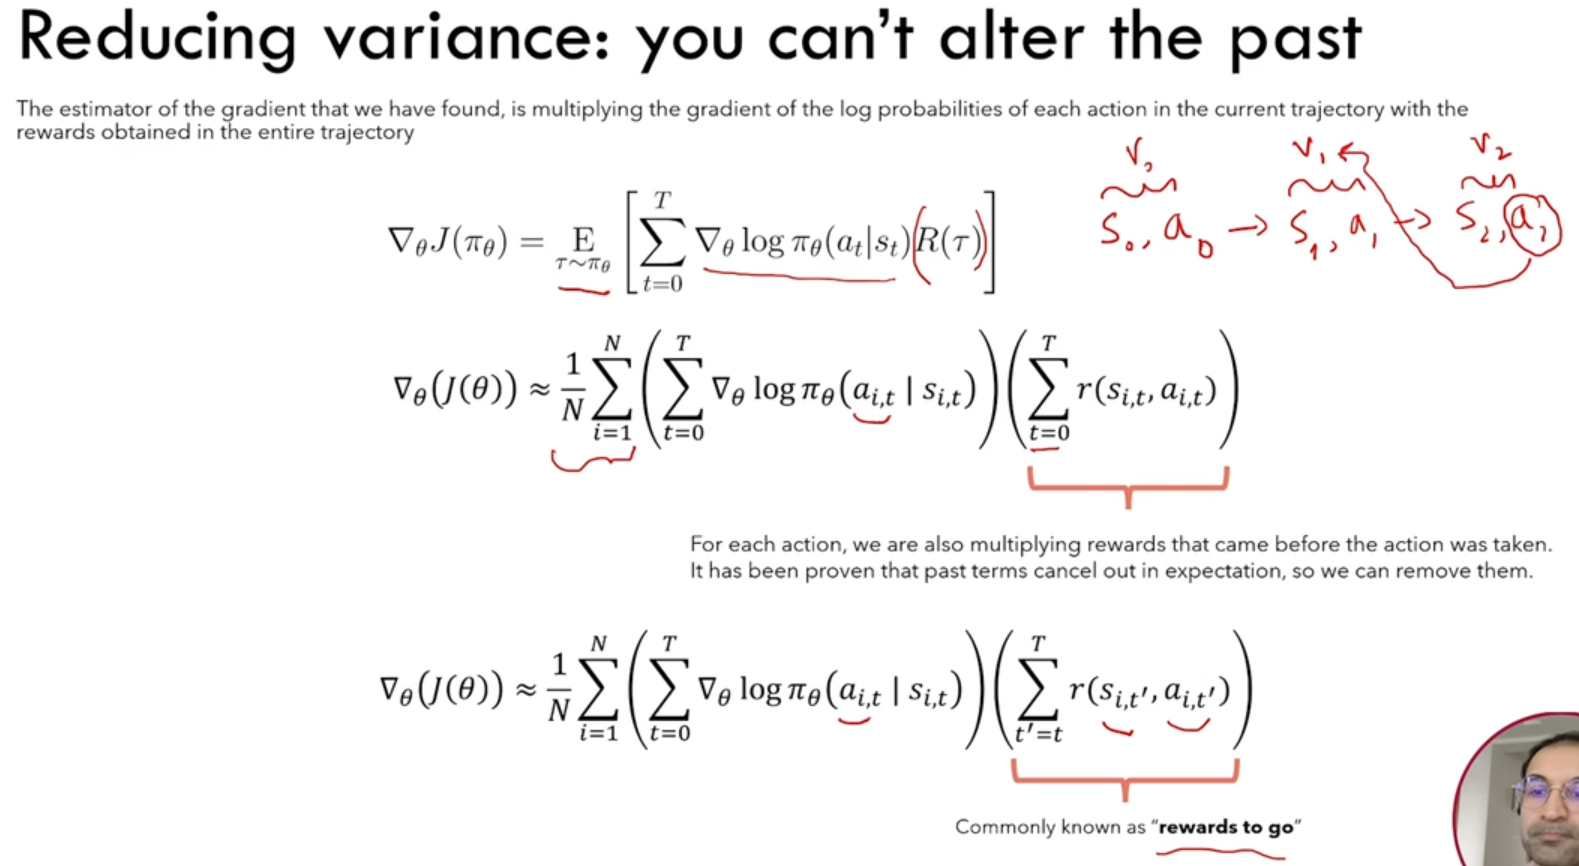
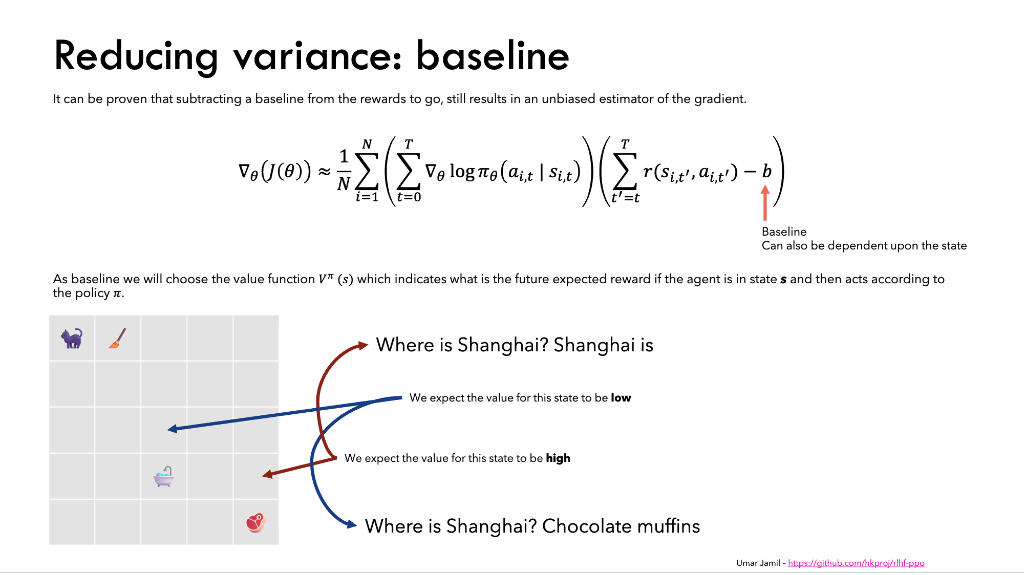
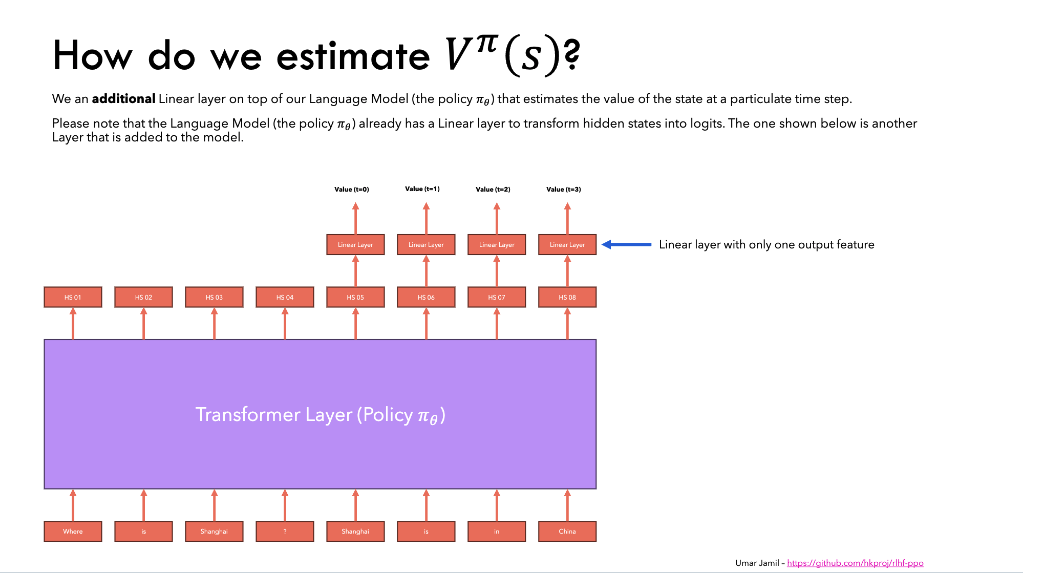
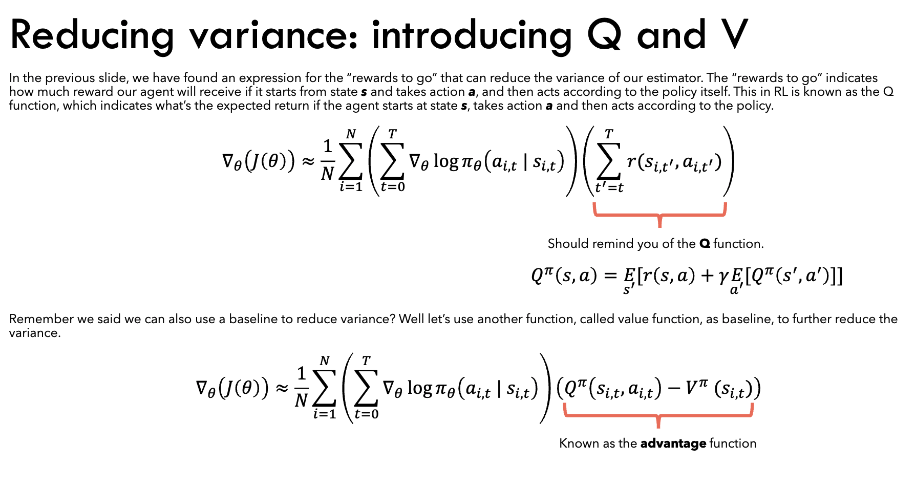
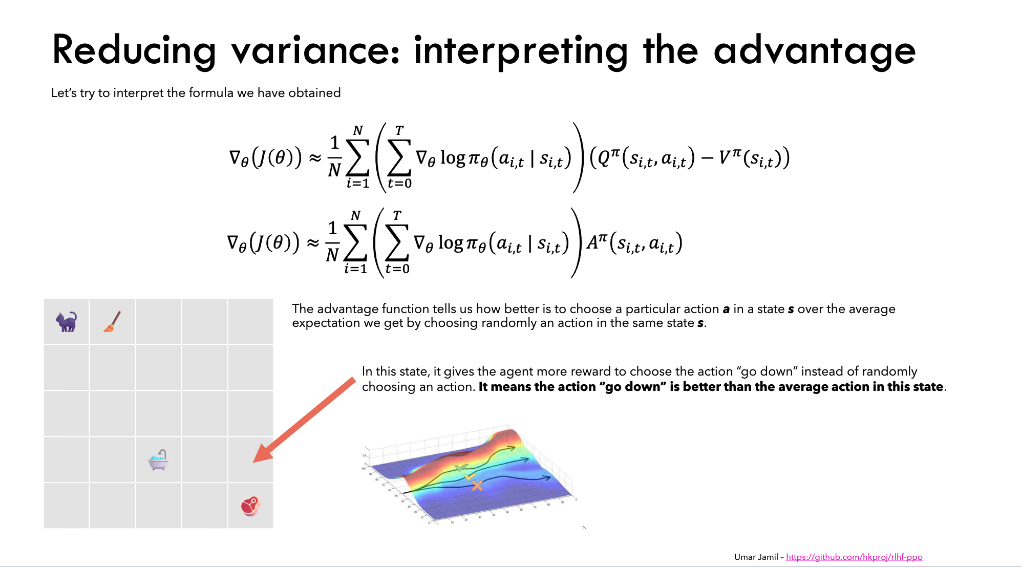
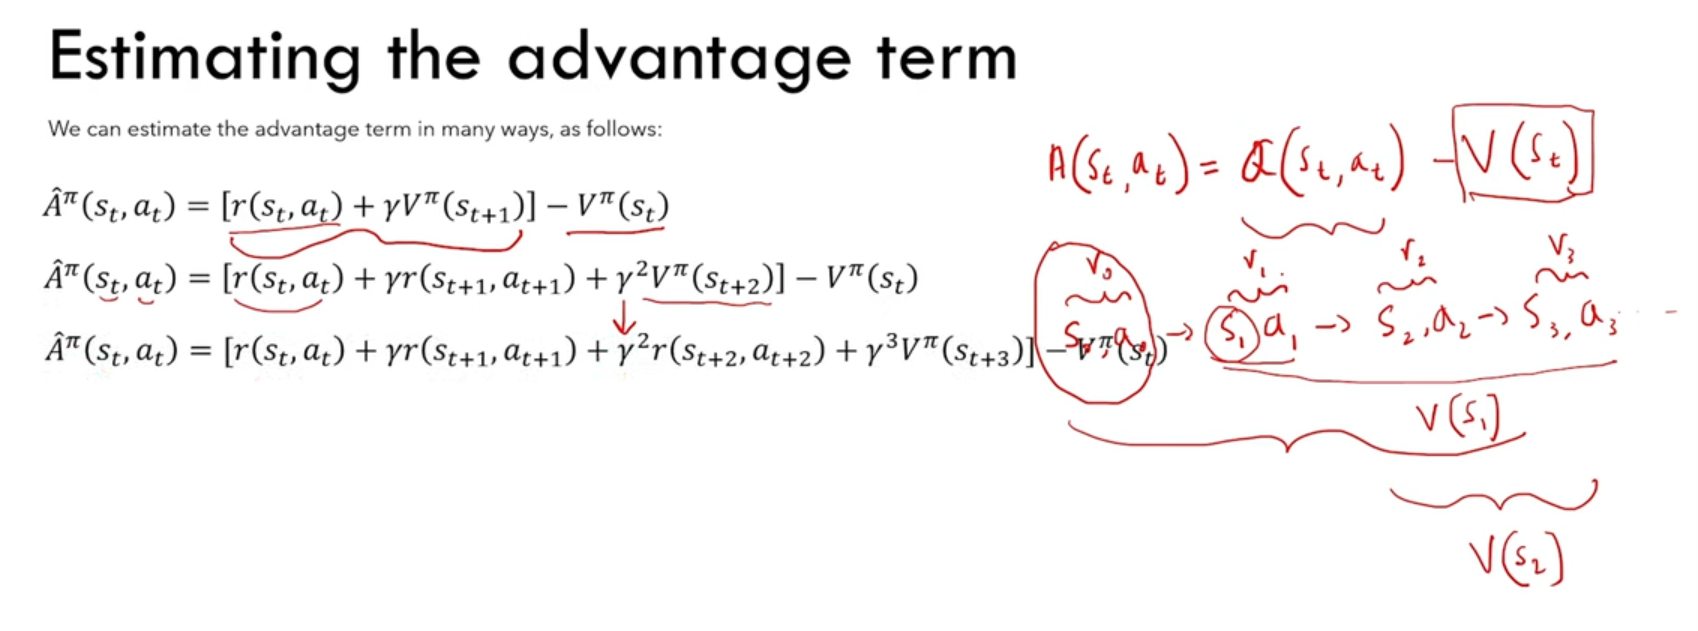
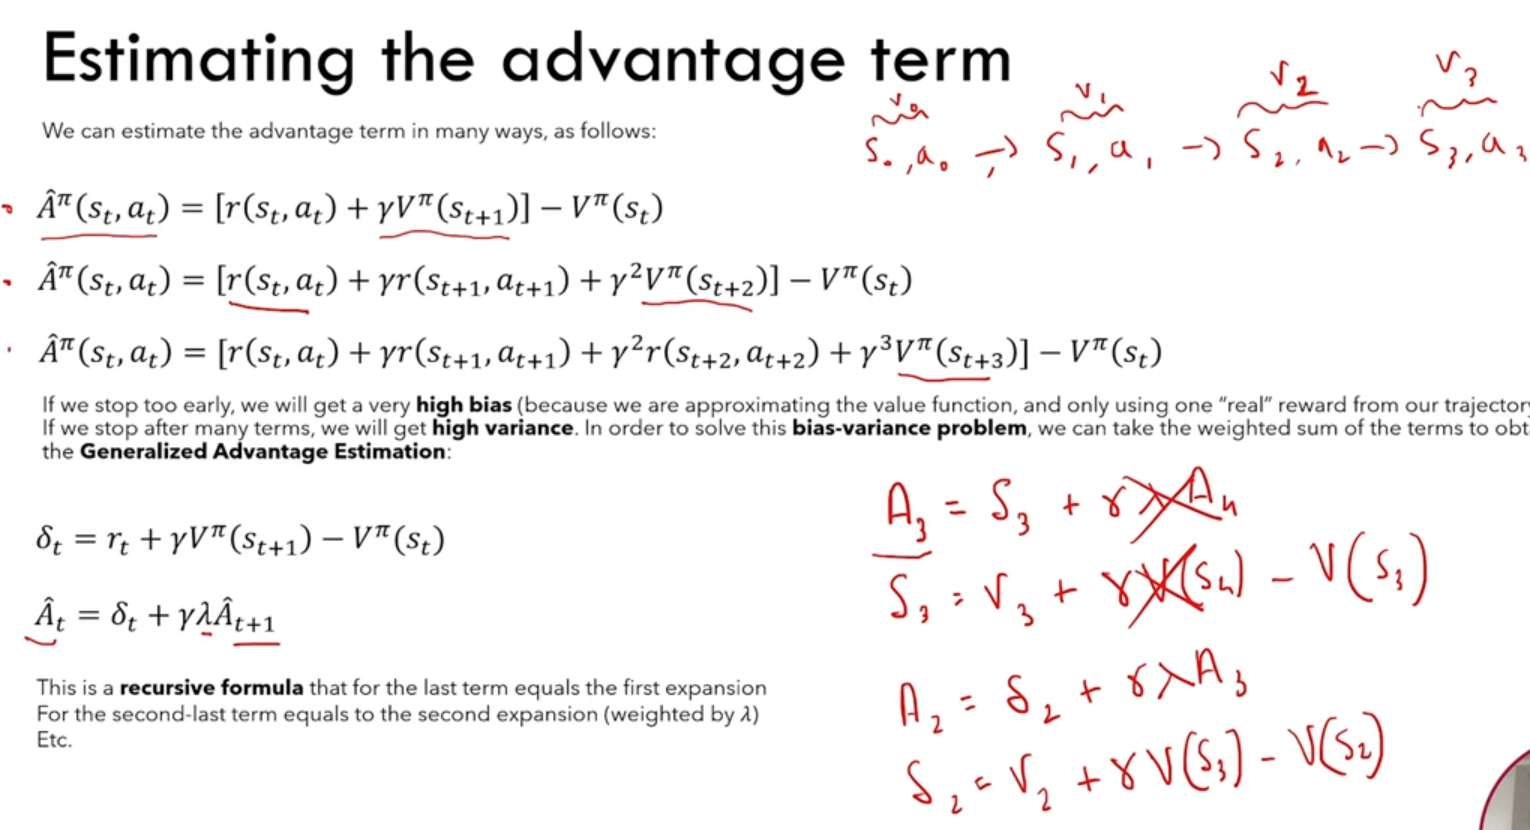
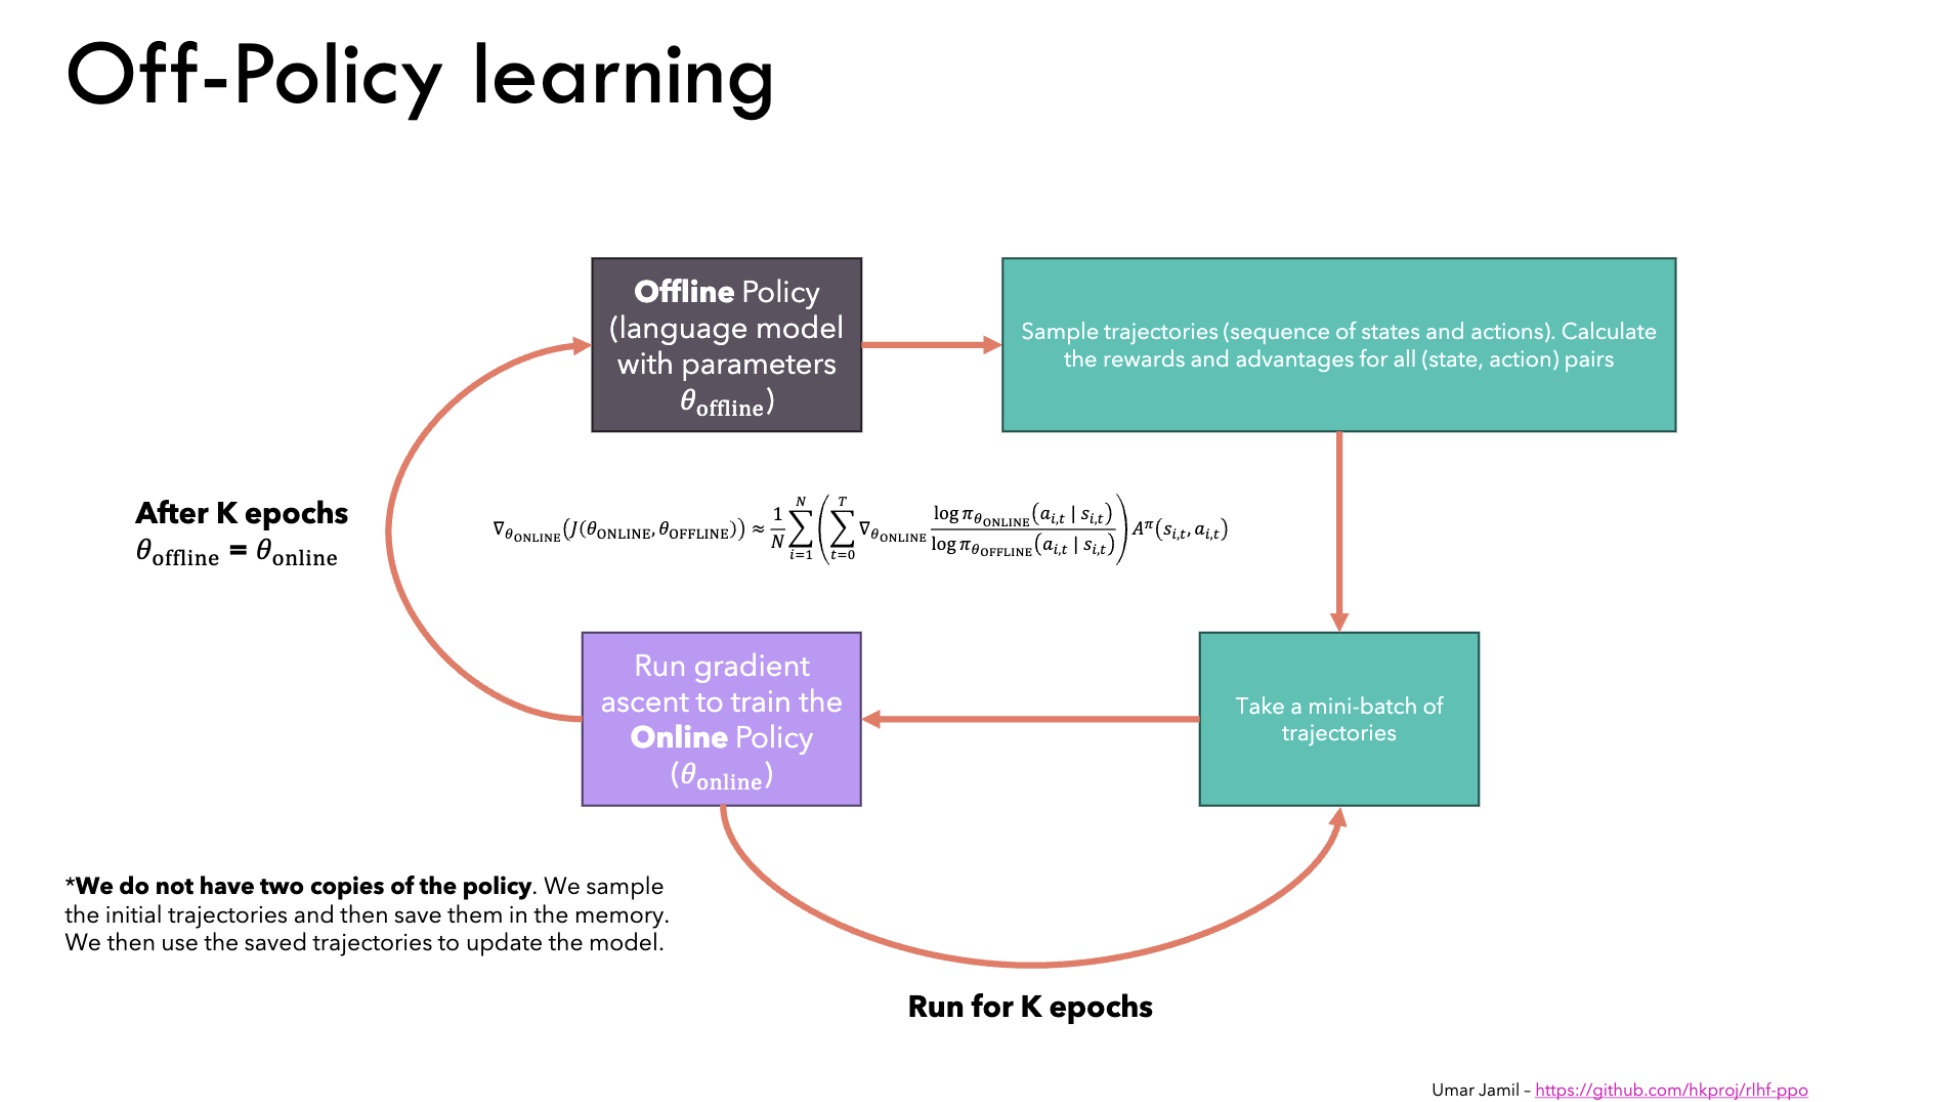
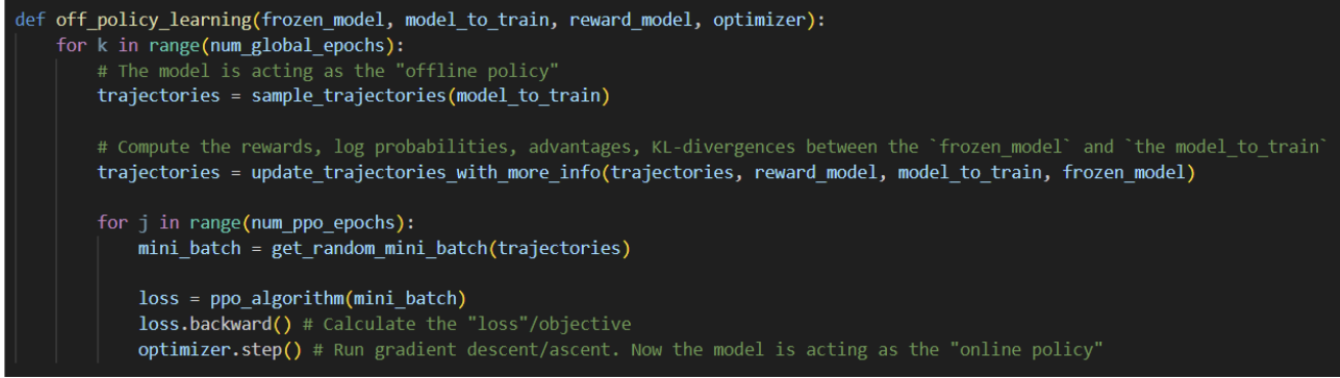
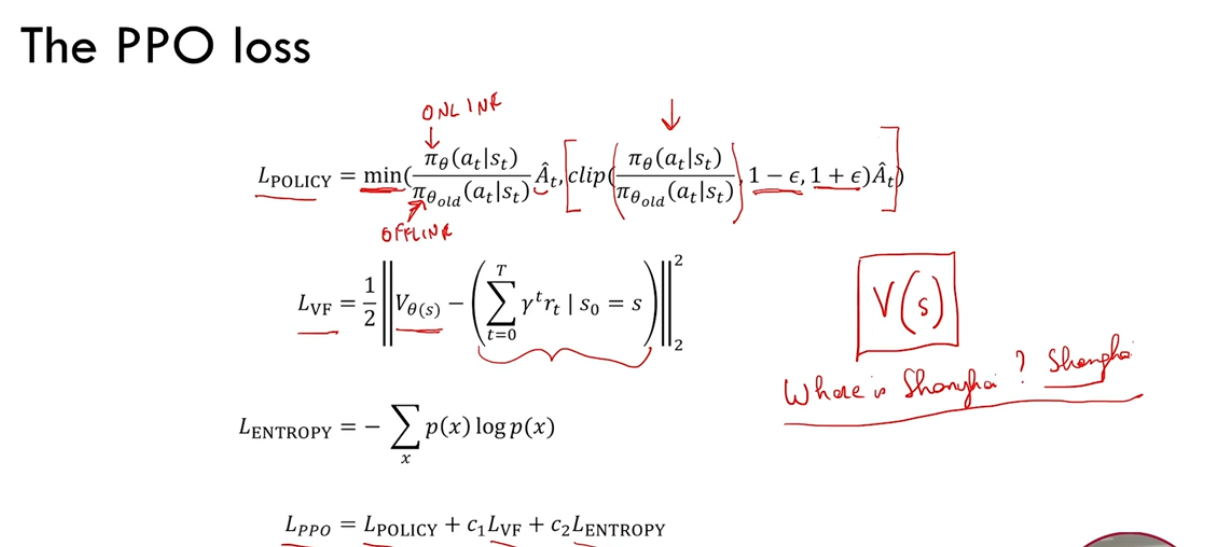
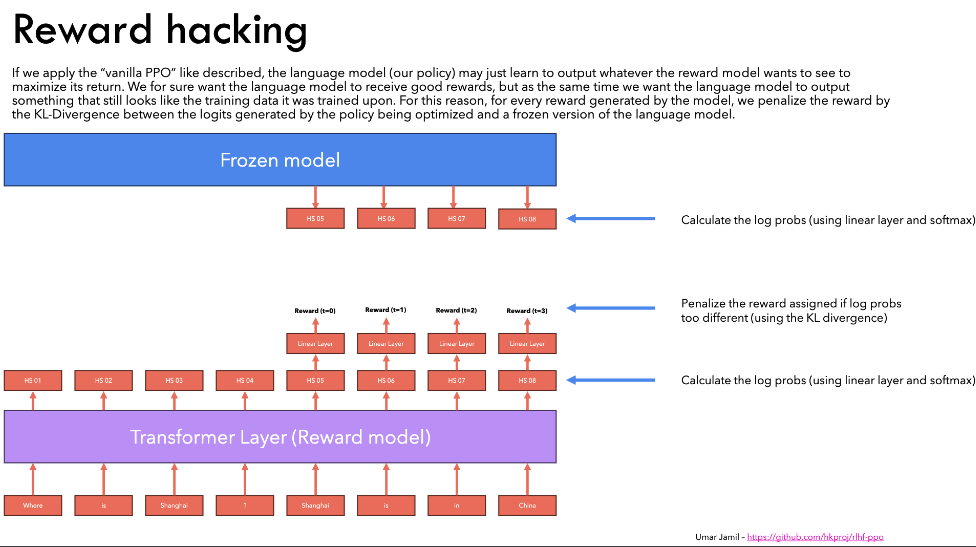

# Direct Preference Optimization (DPO)
An alternative to RLHF is Direct Preference Optimization (DPO). In this method, we directly optimize the language model based on the preferences without using reinforcement learning.

## The Bradley-Terry Model
It's a way of converting a dataset of pereferences into a reward that is given for each pair of questions and answers.The probability of choosing the correct answer over the wrong answer is given as follows: 

$ P(y_w > y_l)  = \frac{e^{r^*(x,y_w)}}{e^{r^*(x,y_w)} + e^{r^*(x,y_l)}}$

where $ r^*(x,y)$ is the true reward function that we are trying to approximate. $y_w$ is the preferred answer and $ y_l$ is the less preferred answer. W stands for winner and l stands for losser :D 


The question is how to train a model to convert a dataset of pereferences into a reward function? We can take the mentioned expression and use a maximum likelihood approach to find the parameters of the reward model. In other words we want to maximize the probability of choosing the right answer over the wrong one. 
![Screenshot 2025-11-07 at 12.02.56 PM.png](<attachment:Screenshot 2025-11-07 at 12.02.56 PM.png>)


The following slide shows us how to drive the loss function to maximize the aforementioned probability.

![Screenshot 2025-11-07 at 12.03.44 PM.png](<attachment:Screenshot 2025-11-07 at 12.03.44 PM.png>)


It's exactly same as the loss function that we had for the reward model in RLHF :D (Earlier in the notebook )

Now we have built a reward model. This model receives a question and answer pair and outputs a scalar reward. The next step is to optimize the language model based on this reward model. In other words optimize the language model to generate answers that get high reward from the reward model. (Maximize the cumulative reward). The next slide is just like what was discuused in the previous section 

![Screenshot 2025-11-07 at 12.15.56 PM.png](<attachment:Screenshot 2025-11-07 at 12.15.56 PM.png>)


![Screenshot 2025-11-07 at 12.21.18 PM.png](<attachment:Screenshot 2025-11-07 at 12.21.18 PM.png>)


Now let's see how DPO is handling this issue. In the DPO paper, they found an anyalytical solution (exact solution) to the optimization problem of maximizing the expected reward while keeping the KL divergence between the optimized model and the pre-trained model under a certain threshold.


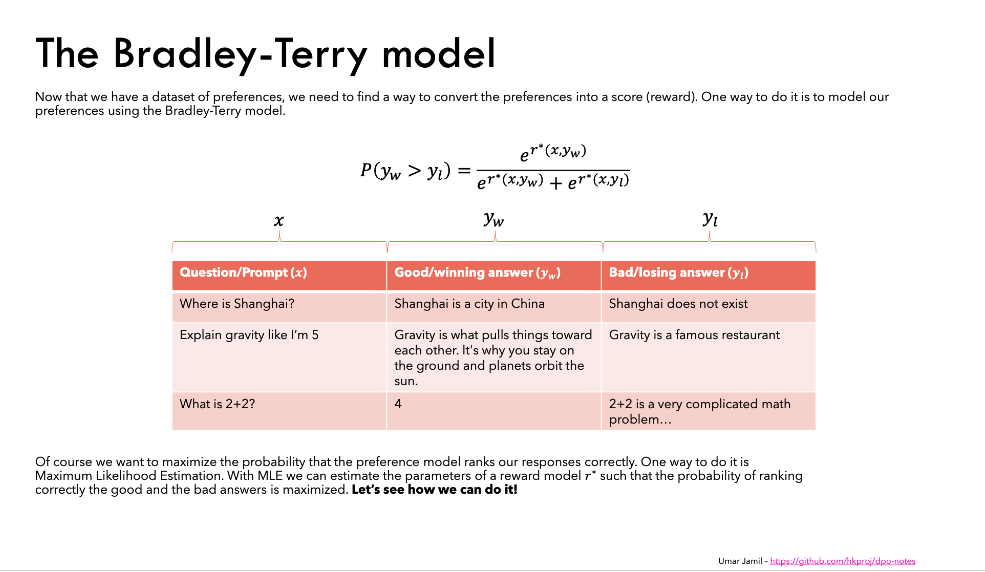
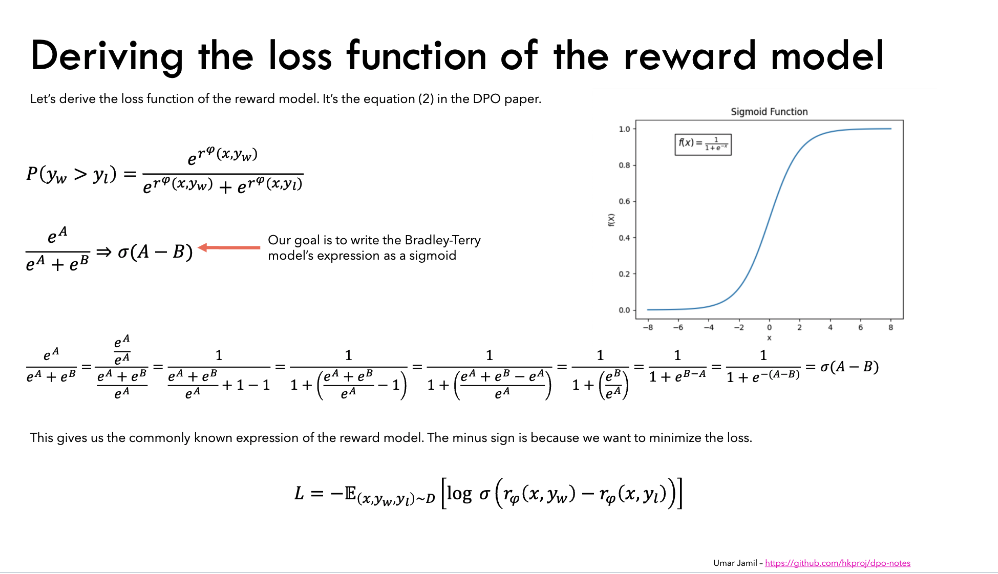
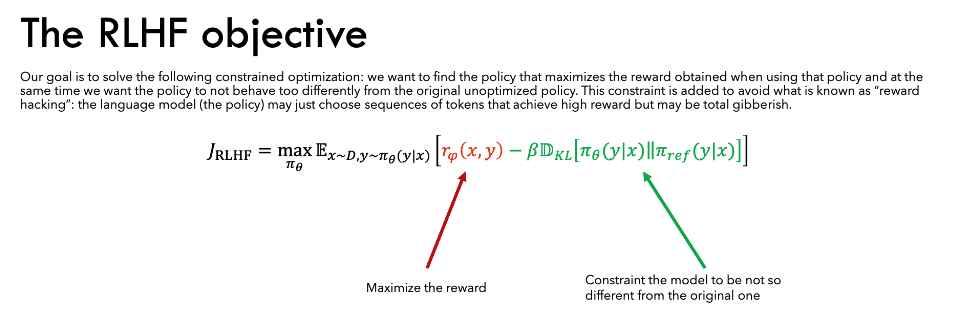
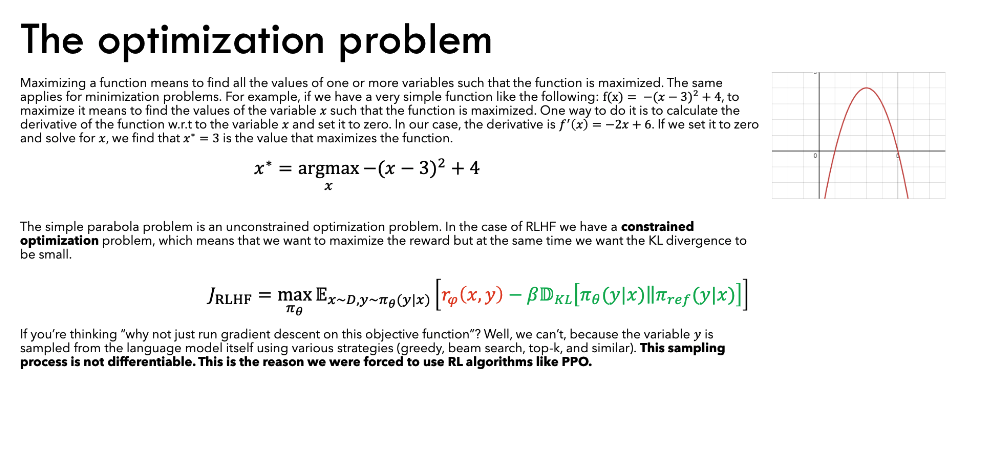